<a href="https://colab.research.google.com/github/MarisaRies/covir/blob/main/COVIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVIR - COVID-19 Increased Risk Facts

Projektarbeit im Kurs "Datenmanagement und -Archivierung" - WS 21/22

Vollständige Dokumentation im [COVIR Projekt Wiki](https://github.com/MarisaRies/covir/wiki)

##Projekt Initialisierung

*   Zurücksetzen aller Variablen
*   Umschalten zw. lokalem und öffentlichem Zugriff
*   Laden externer Bibliotheken
*   Prüfen der Bibliotheksversionen (Vergleich mit Versionen zum Erstellungszeitpunkt)
*   Definition von Pfaden



In [492]:
#Löschen aller vorherigen Ausgaben
%reset -f 

#Schalter für öffentlichen Modus
# True  = öffentlicher Zugang
# False = lokaler Zugang (nur für Projektmitarbeiter)
var_public = True

#Verschlüsselung
#!pip install cape_privacy

#Reproduzierbarkeit
#!pip install dtreeviz
#%pip install pandas

In [493]:
#Lade Bibliotheken
import sqlite3            as sq
from sqlite3 import Error
import pandas             as pd
from pandas.util import hash_pandas_object
import numpy              as np
import math 
import requests
import datetime           as dt
import seaborn            as sns
import matplotlib.pyplot  as plt
import matplotlib         as mpl
import sys
from google.colab import drive 
#from dtreeviz.trees import dtreeviz 

#Konfiguration
%matplotlib inline

In [494]:
#Versionsüberprüfung
#%pip freeze #Anzeige aller Bibliotheken mit Versionsnummern

print("Python Version")
print("Soll: sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)")
print("Ist : {}".format(sys.version_info))
print()

print("Pandas Version")
print("Soll: 1.3.5")
print("Ist : {}".format(pd.__version__))
print()

print("Seaborn Version")
print("Soll: 0.11.2")
print("Ist : {}".format(sns.__version__))
print()

print("Matplotlib Version")
print("Soll: 3.2.2")
print("Ist : {}".format(mpl.__version__))
print()

print("Numpy Version")
print("Soll: 1.19.5")
print("Ist : {}".format(np.__version__))
print()

print("SQLlite Version")
print("Soll: 2.6.0")
print("Ist : {}".format(sq.version))

Python Version
Soll: sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
Ist : sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)

Pandas Version
Soll: 1.3.5
Ist : 1.3.5

Seaborn Version
Soll: 0.11.2
Ist : 0.11.2

Matplotlib Version
Soll: 3.2.2
Ist : 3.2.2

Numpy Version
Soll: 1.19.5
Ist : 1.19.5

SQLlite Version
Soll: 2.6.0
Ist : 2.6.0


In [495]:
#Pfad Definitionen
drive_path        = "/content/drive"
project_root_path = f"{drive_path}/MyDrive/Studium/COVIR"
image_path        = f"{project_root_path}/Bilder/"
git_path          = "https://raw.githubusercontent.com/MarisaRies/covir/main/"
csv_file_path     = f"{project_root_path}/CSV/"

dwh_path_public   = "/content/drive/MyDrive/covir_dwh.db"
dwh_path_download = "https://drive.google.com/file/d/18QvF60r-uzENdDhPWhBi9p2MoyQTSRTE/view?usp=sharing"


*   Aufbau der Staging-Datenbank
*   Anlegen des Tabellenschemas in der Staging-Datenbank


In [496]:
#Lokale in-memory Datenbank aufbauen
def create_staging_db():
  conn_src = None;
  try:
    #Verbindungsaufbau
    conn_src = sq.connect(':memory:')
    print("Staging-Datenbank: In-memory Datenbank erfolgreich eingerichtet")
    return conn_src
  except Error as e:
    print("Staging-Datenbank: Fehler beim Verbinden zu SQLite", e)

#Zugriffs-Cursor für Datenbank abrufen
def get_cursor_staging_db():
  print("Staging-Datenbank: Verbindung erfolgreich zu SQLite")
  return conn_src.cursor()
  
if var_public == False:
  
  #Verbinden von GDrive
  drive.mount("/content/drive", force_remount=True)

  #Aufbau der Staging-Datenbank
  conn_src = create_staging_db()
  cur_src = get_cursor_staging_db()

  #Tabellenschema erzeugen
  cur_src.executescript(requests.get(git_path+'sql/2src_db_create_statements.sql').text)
  conn_src.commit()
  print("Staging-Datenbank: Tabellenschema erfolgreich erstellt")

else:

  print("Staging-Datenbank: Übersprungen in öffentlichen Modus")

Staging-Datenbank: Übersprungen in öffentlichen Modus


##ETL-Prozess

*   Extraktion der Daten aus Datenquelle
*   Transformation der Daten in Zielschema
*   Laden der Daten in das Data-Warehouse

### Extraktion

*   CSV-Daten aus Google-Drive in Dateframes laden, relevante Spalten auswählen
*   Überprüfen, ob sich Datensatz geändert hat
*   Dataframes in Staging-Datenbank laden

> In diesem Schritt wurden ein paar Vereinfachungen angewandt. Es wurde nicht das komplette Schema der CSV Daten in die Zieldatenbank überführt sondern nur der Teil, der zur Beantwortung der Forschungsfrage nötig ist. Üblicherweise sollte das Data-Warehouse möglichst viele Daten enthalten, um vielfältige Abfragen in verschiedenen Szenarien zu ermöglichen. Der große Umfang der Projektarbeit machte diese Einschränkung allerdings nötig. Die wesentlichen Schritte werden dennoch gezeigt.

> Es werden 4 CSV-Datein geladen, die jeweils eine Tabelle in der Staging-Datenbank repräsentieren (Patients, Encounters, Conditions, Immunizations).


In [497]:
if var_public == False:

  #CSV-Daten aus Google-Drive in Dateframes laden, relevante Spalten auswählen
  df_csv_pat = pd.read_csv(csv_file_path+'patients.csv')
  df_csv_pat = df_csv_pat[['Id','BIRTHDATE','DEATHDATE']]

  df_csv_enc = pd.read_csv(csv_file_path+'encounters.csv')
  df_csv_enc = df_csv_enc[['Id','START','STOP','PATIENT','CODE','DESCRIPTION']]

  df_csv_con = pd.read_csv(csv_file_path+'conditions.csv')
  df_csv_con = df_csv_con[['ENCOUNTER','START','STOP','PATIENT','CODE','DESCRIPTION']]

  df_csv_imm = pd.read_csv(csv_file_path+'immunizations.csv')
  df_csv_imm = df_csv_imm[['ENCOUNTER','DATE','PATIENT','CODE','DESCRIPTION']]

  #Dataframes in Staging-Datenbank laden
  df_csv_pat.to_sql('tb_patients', conn_src, if_exists='append', index=False)
  df_csv_enc.to_sql('tb_encounters', conn_src, if_exists='append', index=False)
  df_csv_con.to_sql('tb_conditions', conn_src, if_exists='append', index=False)
  df_csv_imm.to_sql('tb_immunizations', conn_src, if_exists='append', index=False)

  conn_src.commit()

  #Dataframes löschen (werden nicht mehr gebraucht)
  del(df_csv_pat) 
  del(df_csv_enc)
  del(df_csv_con)
  del(df_csv_imm)

  print("ETL-Extraktion: Relevante Daten aus CSV extrahiert und in Staging-Datenbank eingefügt")

else:

  print("ETL-Extraktion: Übersprungen in öffentlichen Modus")


ETL-Extraktion: Übersprungen in öffentlichen Modus


###Transformation

*   Analyse der Daten hinsichtlich Datenqualität
*   Normierung der importierten Werte in einheitliche Wertesysteme
*   Anreichern von benötigten Daten
*   Schema-Transformation von Staging-Datenbank in Sternschema des Data-Warehouse (mittels SQL-Anfragen)

> Die 4 Tabellen der Staging-Datenbank werden in ein Sternschema mit 3 Tabellen (Patients, Encounters, Codes) umgewandelt.
> Außerdem wird das Alter der Patienten aus Geburtstag und Referenztag (Todestag oder Heute) berechnet und gespeichert. Dies reduziert die Last auf das Data-Warehouse bei umfangreichen Anfragen unter Berücksichtigung des Alters




*   Exemplarische Überprüfung der Datenqualität

> Es wird für jede Tabelle überprüft, dass die benötigten Fremdschlüssel (Referenzen zu Patient, Encounter und Code) niemals leer sind.



In [498]:
if var_public == False:

  #Überprüfung der Datenqualität
  #Check 1: Patienten und Encounter-referenz niemals leer

  cur_src.execute(
  """
  SELECT encounter, patient 
  FROM tb_immunizations 
  """
  )
  df_tmp_imm = pd.DataFrame(cur_src.fetchall(), columns=('encounter', 'patient'))
  df_tmp_imm = df_tmp_imm.isnull().mean() * 100

  cur_src.execute(
  """
  SELECT encounter, patient 
  FROM tb_conditions 
  """
  )
  df_tmp_con = pd.DataFrame(cur_src.fetchall(), columns=('encounter', 'patient'))
  df_tmp_con = df_tmp_con.isnull().mean() * 100

  cur_src.execute(
  """
  SELECT patient, code
  FROM tb_encounters 
  """
  )
  df_tmp_enc = pd.DataFrame(cur_src.fetchall(), columns=('patient', 'code'))
  df_tmp_enc = df_tmp_enc.isnull().mean() * 100

  #Datenausgabe
  print("ETL-Transformation: Überprüfung der Rohdatenqualität")
  print()
  print("Prozentsatz von leeren Referenzen in der Tabelle 'tb_immunizations'")
  print(df_tmp_imm)
  print()
  print("Prozentsatz von leeren Referenzen in der Tabelle 'tb_conditions'")
  print(df_tmp_con)
  print()
  print("Prozentsatz von leeren Referenzen in der Tabelle 'tb_encounters'")
  print(df_tmp_enc)

else:

  print("ETL-Transformation: Übersprungen in öffentlichen Modus")

ETL-Transformation: Übersprungen in öffentlichen Modus


In [499]:
if var_public == False:

  #Tabellenschema für Data-Warehouse aus Staging-Datenbank ableiten und temporär in Dataframes speichern
  cur_src.execute(
  """
  SELECT * 
  FROM tb_patients 
  """
  )
  df_src_pat = pd.DataFrame(cur_src.fetchall(), columns=('Id', 'birthdate', 'deathdate'))

  cur_src.execute(
  """
  SELECT 
    enc.Id,
    enc.start as date, 
    enc.patient,
    enc.code,
    enc.description,
    con.code as action_code,
    con.description as action_desc,
    'con' as action_src
  FROM 
    tb_encounters as enc,
    tb_conditions as con
  WHERE
  (
    con.encounter = enc.Id
  )

  UNION

  SELECT 
    enc.Id,
    enc.start as date, 
    enc.patient,
    enc.code,
    enc.description,
    imm.code as action_code,
    imm.description as action_desc,
    'imm' as action_src
  FROM 
    tb_encounters as enc,
    tb_immunizations as imm
  WHERE
  (
    imm.encounter = enc.Id
  );
  """
  )
  df_src_enc = pd.DataFrame(cur_src.fetchall(), columns=('Id', 'date', 'patient', 'code', 'description', 'action_code','action_desc', 'action_src'))

  cur_src.execute(
  """
  SELECT DISTINCT 
    code as action_code, 
    description as action_desc 
  FROM tb_conditions 

  UNION

  SELECT DISTINCT 
    code as action_code, 
    description as action_desc 
  FROM tb_immunizations 
  """
  )
  df_src_cod = pd.DataFrame(cur_src.fetchall(), columns=('action_code', 'action_desc'))

  print("ETL-Transformation: Schema-Transformation von Staging-Datenbank nach Data-Warehouse erfolgreich abgeschlossen")

  #Alter berechnen und als neues Feld dem Dataframe für Patienten-Daten hinzufügen
  df_src_pat['birthdate'] = pd.to_datetime(df_src_pat['birthdate'], format='%Y-%m-%d') #Daten von String in DateTime umwandeln für spätere Berechnung
  df_src_pat['deathdate'] = pd.to_datetime(df_src_pat['deathdate'], format='%Y-%m-%d')

  df_src_pat['EOL'] = df_src_pat.deathdate #Temporäre Spalte für Referenzpunkt der Altersberechnung (Todestag oder Heute)
  df_src_pat['EOL'] = df_src_pat['EOL'].fillna(pd.to_datetime("today")) #Einsetzen von heutigem Datum, falls kein Todestag bekannt

  df_src_pat['age'] =  df_src_pat['EOL'].dt.year - df_src_pat['birthdate'].dt.year #Alter berechnen (Referenztag - Geburtstag) und in neue Spalte 'age' einfügen
  df_src_pat = df_src_pat.drop(columns=['EOL']) #Temporäre Spalte wieder löschen

  print("ETL-Transformation: Alter berechnet und in Patienten-Tabelle eingefügt")

else:

  print("ETL-Transformation: Übersprungen in öffentlichen Modus")

ETL-Transformation: Übersprungen in öffentlichen Modus


### Laden

*   Initialisierung und Verbindungsaufbau zu Data-Warehouse
*   Laden der Dataframes in die Tabellen des Data-Warehouse (Tabellen-Schemata werden automatisch aus den Dataframes abgeleitet)


In [500]:
#Erzeuge Data-Warehouse in öffentlichem Google Drive Ordner
def create_dwh_db(public_path):
  conn_dwh = None;
  try:
    #Verbindungsaufbau
    conn_dwh = sq.connect(public_path)
    print("Data-Warehouse: Lokale Datenbank erfolgreich eingerichtet auf {}".format(public_path))
    return conn_dwh
  except Error as e:
    print("Data-Warehouse: Fehler beim Verbinden zu SQLite", e) 

def get_cursor_dwh_db():
  print("Data-Warehouse: Verbindung erfolgreich zu SQLite")
  return conn_dwh.cursor()


#Aufbau des Data-Warehouse
conn_dwh = create_dwh_db(dwh_path_public)
cur_dwh = get_cursor_dwh_db()

if var_public == False:

  #Dataframes in Data-Warehouse laden
  df_src_pat.to_sql('tb_patients', conn_dwh, if_exists='replace', index=False)
  df_src_enc.to_sql('tb_encounters', conn_dwh, if_exists='replace', index=False)
  df_src_cod.to_sql('tb_codes', conn_dwh, if_exists='replace', index=False)

  conn_dwh.commit()

  #Dataframes löschen (werden nicht mehr gebraucht)
  del(df_src_pat) 
  del(df_src_enc)
  del(df_src_cod)

  print("ETL-Laden: Dataframes erfolgreich in Data-Warehouse geladen")

else:

  print("ETL-Laden: Übersprungen in öffentlichen Modus")

print("Data-Warehouse bereit!")

Data-Warehouse: Lokale Datenbank erfolgreich eingerichtet auf /content/drive/MyDrive/covir_dwh.db
Data-Warehouse: Verbindung erfolgreich zu SQLite
ETL-Laden: Übersprungen in öffentlichen Modus
Data-Warehouse bereit!


## Verbindung zu Data-Warehouse herstellen

*   Data-Warehouse aus öffentlichen Bereich laden (https://drive.google.com/file/d/18QvF60r-uzENdDhPWhBi9p2MoyQTSRTE/view?usp=sharing)
*   Inhalte mit Hash-Summe überprüfen



In [501]:
#Überprüfung Datensatz mit Hash-Funktion

df_dwh_pat = pd.read_sql_query("SELECT * FROM tb_patients", conn_dwh)
df_dwh_pat_hash = hash_pandas_object(df_dwh_pat)
df_dwh_pat_hash = df_dwh_pat_hash.sum()

df_dwh_enc = pd.read_sql_query("SELECT * FROM tb_encounters", conn_dwh)
df_dwh_enc_hash = hash_pandas_object(df_dwh_enc)
df_dwh_enc_hash = df_dwh_enc_hash.sum()

df_dwh_cod = pd.read_sql_query("SELECT * FROM tb_codes", conn_dwh)
df_dwh_cod_hash = hash_pandas_object(df_dwh_cod)
df_dwh_cod_hash = df_dwh_cod_hash.sum()

print("Prüfen, ob Datensätze im Data-Warehouse unverändert sind (Abweichung sollte '0' sein.)")
print()
print("Hash-Summe tb_patients: Soll-Wert       : 2377226860811691868")
print("Hash-Summe tb_patients: Ist-Wert        : {}".format(df_dwh_pat_hash))
print("Hash-Summe tb_patients: Abweichung      : {}".format(2377226860811691868 - df_dwh_pat_hash))
print()
print("Hash-Summe tb_encounters: Soll-Wert     : 4155640383944847724")
print("Hash-Summe tb_encounters: Ist-Wert      : {}".format(df_dwh_enc_hash))
print("Hash-Summe tb_encounters: Abweichung    : {}".format(4155640383944847724 - df_dwh_enc_hash))
print()
print("Hash-Summe tb_codes: Soll-Wert          : -1519849941340395869")
print("Hash-Summe tb_codes: Ist-Wert           : {}".format(df_dwh_cod_hash))
print("Hash-Summe tb_codes: Abweichung         : {}".format(-1519849941340395869 - df_dwh_cod_hash))
print()

Prüfen, ob Datensätze im Data-Warehouse unverändert sind (Abweichung sollte '0' sein.)

Hash-Summe tb_patients: Soll-Wert       : 2377226860811691868
Hash-Summe tb_patients: Ist-Wert        : 2377226860811691868
Hash-Summe tb_patients: Abweichung      : 0

Hash-Summe tb_encounters: Soll-Wert     : 4155640383944847724
Hash-Summe tb_encounters: Ist-Wert      : 4155640383944847724
Hash-Summe tb_encounters: Abweichung    : 0

Hash-Summe tb_codes: Soll-Wert          : -1519849941340395869
Hash-Summe tb_codes: Ist-Wert           : -1519849941340395869
Hash-Summe tb_codes: Abweichung         : 0



##Daten Analyse

*   Übersicht über Struktur (vorhandene Spalten) und Art (verwendete Datentypen) der Daten
*   Übersicht über Komplexität des Datensatzes (Größe der x- und y-Dimensionen)
*   Grafische Aufbereitung der Werteverteilungen für relevante Spalten

###Tabelle TB_PATIENTS

*   Patientenstammdaten

In [502]:
#Übersicht Patienten Tabelle
df_dwh_pat = pd.read_sql_query("SELECT * FROM tb_patients", conn_dwh)
df_dwh_pat.info()
df_dwh_pat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         1050 non-null   object
 1   birthdate  1050 non-null   object
 2   deathdate  50 non-null     object
 3   age        1050 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 32.9+ KB


,Id,birthdate,deathdate,age
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,2002-05-05 00:00:00,None,20
1,2812f4fc-6aba-0033-728b-7e569bb8adcc,1942-05-24 00:00:00,None,80
2,9b1a203a-6368-49a5-0c79-45c32729bc17,2013-06-15 00:00:00,None,9
3,52a250a9-24e4-ec9b-91d6-c38cf1b10fc0,1997-11-16 00:00:00,None,25
4,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28 00:00:00,None,57
...,...,...,...,...
1045,edab2899-dac4-a19d-59e2-a9bea7b95cab,1999-08-12 00:00:00,None,23
1046,d1065043-2a5f-2d0e-1dd0-cb7f31e6d340,1960-04-30 00:00:00,None,62
1047,4c523ab1-3255-911a-7eef-3bc3e48b7b05,1961-11-11 00:00:00,None,61
1048,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,1920-02-27 00:00:00,2020-03-28 00:00:00,100




*   Altersverteilung über alle Patienten



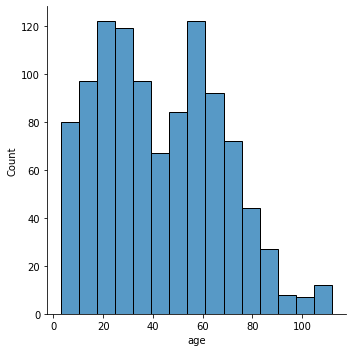

Altersverteilung über alle 1050 Patienten


In [503]:
#Grafik Altersverteilung
var_pat_total = len(df_dwh_pat)

#Datenausgabe
sns.displot(df_dwh_pat["age"])
#plt.savefig(image_path+'Histogramm_Patientenalter.png')
plt.show()

print("Altersverteilung über alle {} Patienten".format(var_pat_total))



*   Verteilung lebendige Patienten im Vergleich zu bereits verstorbenen



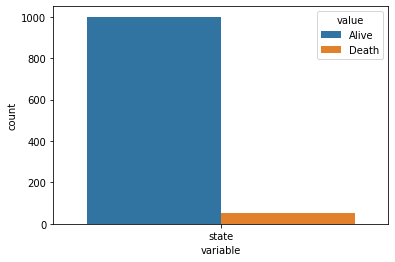

Verteilung 'lebendig' und 'tot' über alle 1050 Patienten:
Alive    1000
Death      50
Name: state, dtype: int64


In [504]:
#Grafik Alive vs Death
df_dwh_pat["state"] = df_dwh_pat["deathdate"] #Kopieren der Spalte Todestag in neue Spalte "state"
df_dwh_pat["state"] = df_dwh_pat["state"].fillna('Alive') #Normalisierung von NaN nach 'Alive'
df_dwh_pat["state"] = df_dwh_pat["state"].replace(['[^Alive]'], '', regex = True) #Normalisierung jeder Zeile ungleich 'Alive' nach '' mittels regulärem Ausdruck
df_dwh_pat["state"] = df_dwh_pat["state"].replace([''], 'Death') #Ersetzen von '' mit 'Death'

df_dist_alive = df_dwh_pat["state"].value_counts() #Aufschlüsseln der Werteverteilung

var_pat_alive = df_dist_alive.get('Alive')
var_pat_death = df_dist_alive.get('Death')

#Datenausgabe
sns.countplot(x="variable", hue= "value", data=pd.melt(df_dwh_pat[["state"]]))
#plt.savefig(image_path+'Histogramm_Lebendig-Tot.png')
plt.show()

print("Verteilung 'lebendig' und 'tot' über alle {} Patienten:".format(var_pat_total))
print(df_dist_alive)

###Tabelle TB_ENCOUNTERS


*   Stammdaten zu jeder Begegnung aus medizinischem Anlass (z.b. Grunduntersuchung oder Notfall)
*   Auflistung der festgestellten Symptome und/oder durchgeführter Immunisierungen (action_code + action_desc, action_src klassifiziert Art der Aktion)

In [505]:
#Übersicht Encounter (Begegnung) Tabelle
df_dwh_enc = pd.read_sql_query("SELECT * FROM tb_encounters", conn_dwh)
df_dwh_enc.info()
df_dwh_enc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500 entries, 0 to 19499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           19500 non-null  object
 1   date         19500 non-null  object
 2   patient      19500 non-null  object
 3   code         19500 non-null  object
 4   description  19500 non-null  object
 5   action_code  19500 non-null  object
 6   action_desc  19500 non-null  object
 7   action_src   19500 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


,Id,date,patient,code,description,action_code,action_desc,action_src
0,00009d66-b01e-da8a-2568-a2544e9fcd95,2019-01-14T01:10:19Z,bb509471-750f-014a-6a5a-06e765b743d2,410620009,Well child visit (procedure),20,DTaP,imm
1,0003495f-5d93-2faf-6301-ec3ec5a60198,2020-08-14T18:04:43Z,62d78287-135c-6e97-08a3-ae3b972fe7aa,410620009,Well child visit (procedure),10,IPV,imm
2,0003495f-5d93-2faf-6301-ec3ec5a60198,2020-08-14T18:04:43Z,62d78287-135c-6e97-08a3-ae3b972fe7aa,410620009,Well child visit (procedure),140,Influenza seasonal injectable preservative ...,imm
3,0003495f-5d93-2faf-6301-ec3ec5a60198,2020-08-14T18:04:43Z,62d78287-135c-6e97-08a3-ae3b972fe7aa,410620009,Well child visit (procedure),20,DTaP,imm
4,0003495f-5d93-2faf-6301-ec3ec5a60198,2020-08-14T18:04:43Z,62d78287-135c-6e97-08a3-ae3b972fe7aa,410620009,Well child visit (procedure),21,varicella,imm
...,...,...,...,...,...,...,...,...
19495,fff70f86-6d30-cf4a-6b28-86969106b262,2020-03-09T16:48:31Z,a7769a00-2471-91d2-b0d5-ac7c7bfe1c1e,1505002,Hospital admission for isolation (procedure),233604007,Pneumonia (disorder),con
19496,fff70f86-6d30-cf4a-6b28-86969106b262,2020-03-09T16:48:31Z,a7769a00-2471-91d2-b0d5-ac7c7bfe1c1e,1505002,Hospital admission for isolation (procedure),271825005,Respiratory distress (finding),con
19497,fff70f86-6d30-cf4a-6b28-86969106b262,2020-03-09T16:48:31Z,a7769a00-2471-91d2-b0d5-ac7c7bfe1c1e,1505002,Hospital admission for isolation (procedure),389087006,Hypoxemia (disorder),con
19498,fff70f86-6d30-cf4a-6b28-86969106b262,2020-03-09T16:48:31Z,a7769a00-2471-91d2-b0d5-ac7c7bfe1c1e,1505002,Hospital admission for isolation (procedure),65710008,Acute respiratory failure (disorder),con



*   Verteilung der Gründe für eine medizinische Begegnung


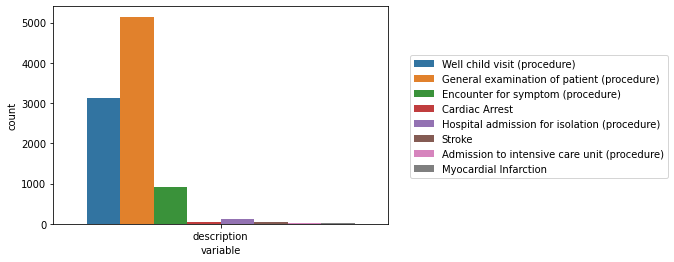

Verteilung der Terminarten (Begegnunsgründe) über alle 9444 Begegnungen:
General examination of patient (procedure)      5147
Well child visit (procedure)                    3120
Encounter for symptom (procedure)                905
Hospital admission for isolation (procedure)     129
Stroke                                            54
Cardiac Arrest                                    47
Admission to intensive care unit (procedure)      22
Myocardial Infarction                             20
Name: description, dtype: int64


In [506]:
#Abfrage alle Begenungen (Redundanzen durch Stern-Schema werden eliminiert)
df_dwh_enc_dis = pd.read_sql_query(
    """
      SELECT DISTINCT 
        Id, 
        date, 
        patient, 
        code, 
        description 
      FROM 
        tb_encounters
    """
    , conn_dwh)

df_dist_enc_code = df_dwh_enc_dis["description"].value_counts() #Aufschlüsseln der Werteverteilung

#Datenausgabe
sns.countplot(x="variable", hue= "value", data=pd.melt(df_dwh_enc_dis[["description"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
#plt.savefig(image_path+'Histogramm_Begegnungsgrund.png')
plt.show()

print("Verteilung der Terminarten (Begegnunsgründe) über alle {} Begegnungen:".format(len(df_dwh_enc_dis["description"])))
print(df_dist_enc_code)


*   Zeitliche Verteilung der medizinischen Begegnungen


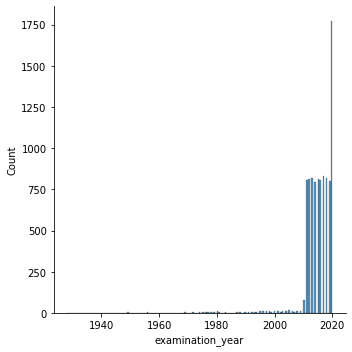

Zeitliche Verteilung aller 9444 Begegnungen
2020    1772
2017     831
2018     818
2013     817
2012     814
        ... 
1952       1
1966       1
1953       1
1973       1
1935       1
Name: examination_year, Length: 77, dtype: int64


In [507]:
#Grafik zeitliche Verteilung der Begnungen (Jahr)
df_dwh_enc_dis["examination_year"] = pd.DatetimeIndex(df_dwh_enc_dis['date']).year #Normalisierung auf Jahr, um Plot zu verbessern

df_dist_enc_year = df_dwh_enc_dis["examination_year"].value_counts() #Aufschlüsseln der Werteverteilung

#Datenausgabe
sns.displot(df_dwh_enc_dis["examination_year"])
#plt.savefig(image_path+'Histogramm_Begegnungsverteilung.png')
plt.show()

print("Zeitliche Verteilung aller {} Begegnungen".format(len(df_dwh_enc_dis["date"])))
print(df_dist_enc_year)



*   Verteilung aller festgestellten Symptome



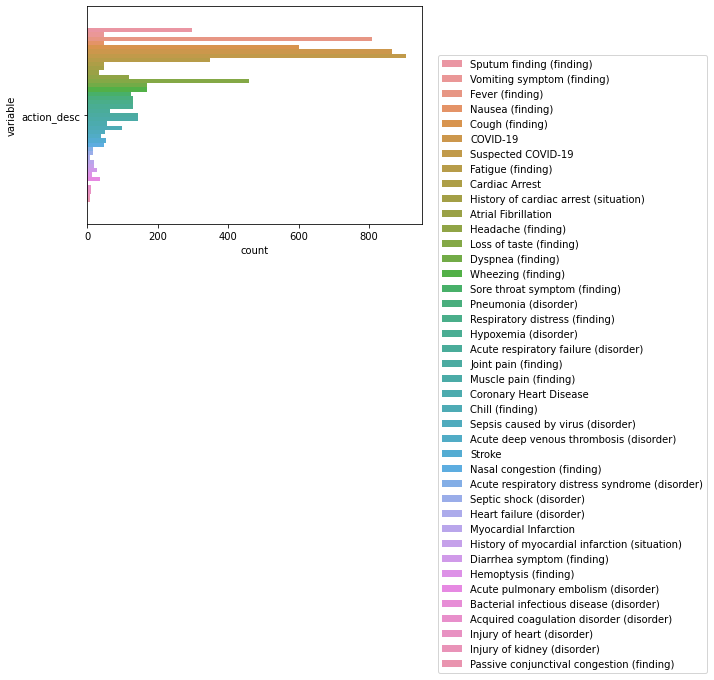

Verteilung der festgestellten Symptome über alle 6375 Datenpunkte:
Suspected COVID-19         905
COVID-19                   865
Fever (finding)            807
Cough (finding)            600
Loss of taste (finding)    459
Name: action_desc, dtype: int64


In [508]:
#Abfrage aller Symptom-Beobachtungen
df_dwh_con = pd.read_sql_query(
    """
    SELECT * 
    FROM tb_encounters 
    WHERE action_src = 'con'
    """
    , conn_dwh)

df_dist_con_code = df_dwh_con["action_desc"].value_counts() #Aufschlüsseln der Werteverteilung

#Datenausgabe
sns.countplot(y="variable", hue= "value", data=pd.melt(df_dwh_con[["action_desc"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
#plt.savefig(image_path+'Histogramm_Symptomverteilung.png')
plt.show()

print("Verteilung der festgestellten Symptome über alle {} Datenpunkte:".format(len(df_dwh_con["action_desc"])))
print(df_dist_con_code.head())



*   Verteilung aller verabreichten Immunisierungen



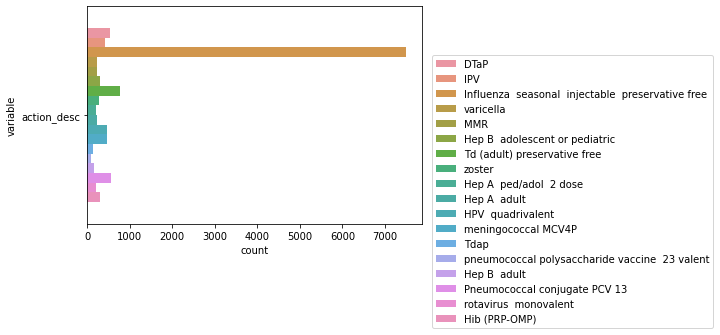

Verteilung der verabreichten Immunisierungen über alle 13125 Datenpunkte:
Influenza  seasonal  injectable  preservative free    7498
Td (adult) preservative free                           772
Pneumococcal conjugate PCV 13                          553
DTaP                                                   534
HPV  quadrivalent                                      475
meningococcal MCV4P                                    469
IPV                                                    430
Hib (PRP-OMP)                                          309
Hep B  adolescent or pediatric                         298
zoster                                                 286
Hep A  adult                                           229
MMR                                                    227
varicella                                              227
Hep A  ped/adol  2 dose                                214
rotavirus  monovalent                                  204
Hep B  adult                             

In [509]:
#Abfrage aller durchgeführten Immunisierungen
df_dwh_imm = pd.read_sql_query(
    """
    SELECT * 
    FROM tb_encounters 
    WHERE action_src = 'imm'
    """
    , conn_dwh)

df_dist_imm_code = df_dwh_imm["action_desc"].value_counts() #Aufschlüsseln der Werteverteilung

#Datenausgabe
sns.countplot(y="variable", hue= "value", data=pd.melt(df_dwh_imm[["action_desc"]]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
#plt.savefig(image_path+'Histogramm_Impfungsverteilung.png')
plt.show()

print("Verteilung der verabreichten Immunisierungen über alle {} Datenpunkte:".format(len(df_dwh_imm["action_desc"])))
print(df_dist_imm_code)

###Tabelle TB_CODES



*   Übersicht über alle Codes und deren textuelle Beschreibung aus SNOMED-CT



In [510]:
#Übersicht Codes Tabelle
df_dwh_pat = pd.read_sql_query("SELECT * FROM tb_codes ORDER BY action_code", conn_dwh)
df_dwh_pat.info()
df_dwh_pat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   action_code  59 non-null     object
 1   action_desc  59 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


,action_code,action_desc
0,10,IPV
1,113,Td (adult) preservative free
2,114,meningococcal MCV4P
3,115,Tdap
4,119,rotavirus monovalent


##Hypothesen

###Hypothese 1: Geriatrische Patienten (65+) erkranken häufiger an Covid-19.

*   Vergleich auf 2 Dimensionen ( Alter, Covid-Positiv)
*   Vergleich Verhältnis nicht-geriatrischer Patienten (<65) zu geriatrischen Patienten (>=65)
*   Vergleich beider Gruppen hinsichtlich COVID-19-Positiv und Negativ-Diagnose
*   Errechnen und Vergleich des Erkrankungsverhältnisses zur Beantwortung der Hypothese



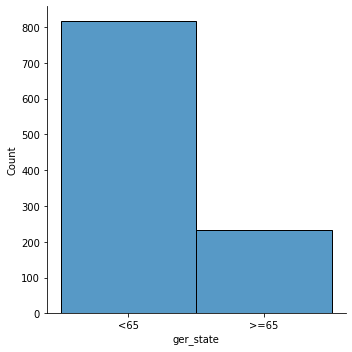

Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) über alle 1050 Datenpunkte:
<65     817
>=65    233
Name: ger_state, dtype: int64


In [511]:
#Abfrage aller Patienten mit ihrem Alter
df_dwh_hyp1_1 = pd.read_sql_query(
    """
    SELECT DISTINCT 
      pat.Id,
      pat.age
    FROM 
      tb_patients as pat
    """
    , conn_dwh)

df_dwh_hyp1_1['ger_state'] = [">=65" if x >=65 else "<65" for x in df_dwh_hyp1_1['age']] #Umwandlung der Spalte Alter in feste Dimensionen [>=65] und [<65]

df_dist_pat_ger = df_dwh_hyp1_1["ger_state"].value_counts() #Aufschlüsseln der Werteverteilung
var_pat_nger = df_dist_pat_ger.get('<65')
var_pat_ger = df_dist_pat_ger.get('>=65')

#Datenausgabe
sns.displot(df_dwh_hyp1_1["ger_state"])
#plt.savefig(image_path+'Histogramm_geriatrischer_Zustand.png')
plt.show()

print("Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) über alle {} Datenpunkte:".format(len(df_dwh_hyp1_1["ger_state"])))
print(df_dist_pat_ger)

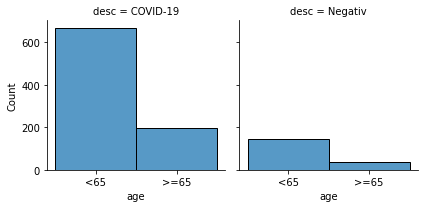

Linke Seite: Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) für Covid-19-positive Fälle
<65     670
>=65    195
Name: age, dtype: int64

Rechte Seite: Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) für Covid-19-negative Fälle
<65     147
>=65     38
Name: age, dtype: int64

Anzahl aller COVID-19-positiver und negativer Fälle
COVID-19    865
Negativ     185
Name: desc, dtype: int64


In [512]:
#Abfrage aller Patienten mit Alter und Covid-19-Status ('COVID-19' wenn positiv, '' wenn negativ)
df_dwh_hyp1_2 = pd.read_sql_query(
    """
    SELECT DISTINCT(temp.patient), pat.age, temp.desc

    FROM (
      SELECT 
        enc.patient as patient, 
        action_desc as desc
      FROM 
        tb_encounters as enc
      WHERE 
        action_code = '840539006'

      UNION

      SELECT 
        Id, 
        '' as action_desc
      FROM 
        tb_patients
    ) as temp JOIN tb_patients as pat ON pat.Id = temp.patient 
    GROUP BY patient
    """
    , conn_dwh)

df_dwh_hyp1_2["desc"] = df_dwh_hyp1_2["desc"].replace([''], 'Negativ') #Ersetzen von leerem String '' mit dem String 'Negativ'
df_dwh_hyp1_2['age'] = [">=65" if x >=65 else "<65" for x in df_dwh_hyp1_2['age']] #Umwandlung der Spalte Alter in feste Dimensionen [>=65] und [<65]

df_pat_covpos = df_dwh_hyp1_2.loc[df_dwh_hyp1_2['desc'] == 'COVID-19'] #Filtern nach allen COVID-19-positiven Patienten
df_dist_pat_covpos = df_pat_covpos['age'].value_counts() #Aufschlüsseln der Werteverteilung

var_pat_nger_covpos = df_dist_pat_covpos.get('<65')
var_pat_ger_covpos  = df_dist_pat_covpos.get('>=65')

df_pat_covneg = df_dwh_hyp1_2.loc[df_dwh_hyp1_2['desc'] == 'Negativ'] #Filtern nach allen COVID-19-negativen Patienten
df_dist_pat_covneg = df_pat_covneg['age'].value_counts() #Aufschlüsseln der Werteverteilung

var_pat_nger_covneg = df_dist_pat_covneg.get('<65')
var_pat_ger_covneg  = df_dist_pat_covneg.get('>=65')

df_dist_pat_ger_cov = df_dwh_hyp1_2['desc'].value_counts() #Aufschlüsseln der Werteverteilung
var_pat_total_covpos = df_dist_pat_ger_cov.get('COVID-19')

#Datenausgabe
g = sns.FacetGrid(df_dwh_hyp1_2, col="desc")
g.map(sns.histplot, "age")
#plt.savefig(image_path+'Histogramm_geriatrischer_Zustand.png')
plt.show()

print("Linke Seite: Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) für Covid-19-positive Fälle")
print(df_dist_pat_covpos)
print()
print("Rechte Seite: Anzahl nicht-geriatrischen Patienten (<65) zu geriatrischer Patienten (>=65) für Covid-19-negative Fälle")
print(df_dist_pat_covneg)
print()
print("Anzahl aller COVID-19-positiver und negativer Fälle")
print(df_dist_pat_ger_cov)

In [513]:
#Berechnung der Verhältnisse
var_ratio_covpos      = math.ceil((var_pat_total_covpos / var_pat_total)*100) #Verhältnis aller Patienten über 65 mit positiver COVID-19-Diagnose
var_ratio_nger_covpos = math.ceil((var_pat_nger_covpos / var_pat_nger)*100) #Verhältnis aller Patienten unter 65 mit positiver COVID-19-Diagnose
var_ratio_ger_covpos  = math.ceil((var_pat_ger_covpos / var_pat_ger)*100) #Verhältnis aller Patienten über 65 mit positiver COVID-19-Diagnose

print("{}% aller Patienten haben eine positive COVID-19-Diagnose".format(var_ratio_covpos))
print("{}% aller Patienten unter 65 haben eine positive COVID-19-Diagnose".format(var_ratio_nger_covpos))
print("{}% aller Patienten über 65 haben eine positive COVID-19-Diagnose".format(var_ratio_ger_covpos))

83% aller Patienten haben eine positive COVID-19-Diagnose
83% aller Patienten unter 65 haben eine positive COVID-19-Diagnose
84% aller Patienten über 65 haben eine positive COVID-19-Diagnose


Die Hypothese #1 lässt sich anhand der zur Verfügung stehenden Daten nicht belegen.
Die Wahrscheinlichkeit einer positiven COVID-19-Diagnose ist über alle Altersgruppen nahezu identisch!

###Hypothese 2: Patienten mit Fieber, Atemnot und Geschmacksverlust haben eine hohe Wahrscheinlichkeit an Covid-19 erkrankt zu sein.

SNOMED-CT Kodierungen aus Datenbank
* Fieber = '386661006'
* Atemnot = '267036007'
* Geschmacksverlust = '36955009'

Im Rahmen der Untersuchung der Hypothese wird das Verhältnis von Covid-19-positiven und -negativen Patienten verglichen, die einerseits gleichzeitig an Fieber, Atemnot und Geschmacksverlust leiden sowie anderseits keines, eines oder nur 2 dieser Symptome aufweisen.

Fällt die Auswertung positiv aus, können diese 3 Symptome als sichere Indikatoren für eine COVID-19 Infektion herangezogen werden.






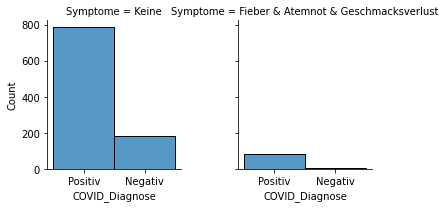

Linke Seite: Verhältnis der COVID-19-Diagnosen für Patienten, die nicht alle 3 Symptome gleichzeitig hatten
Positiv    784
Negativ    182
Name: COVID_Diagnose, dtype: int64

Rechte Seite: Verhältnis der COVID-19-Diagnosen für Patienten, die alle 3 Symptome (Fieber, Atemnot, Geschmacksverlust) gleichzeitig hatten
Positiv    81
Negativ     3
Name: COVID_Diagnose, dtype: int64


In [514]:
#Die Abfrage verbindet folgende 2 Teilabfragen
#  Abfrage aller Patienten mit zugehöriger COVID-19-Diagnose ('Positiv' falls positiv, NaN falls negativ)
#  Abfrage aller Patienten mit zugehörigem Symptom-Status ('Fieber & Atemnot & Geschmacksverlust' falls alle 3 Symptome beobachtet wurden, NaN falls nicht alle 3 beobachtet wurden)
df_dwh_hyp2_1 = pd.read_sql_query(
    """
    SELECT 
      tb1.Id,
      tb1.COVID_Diagnose,
      tb2.Symptome
    FROM
      (
        SELECT
          pat.Id,
          sympat.COVID_Diagnose
        FROM
          tb_patients AS pat
          LEFT JOIN
          (
          SELECT 
            con1.patient, 
            'Positiv' as COVID_Diagnose
          FROM 
	          tb_encounters AS con1,
            tb_patients AS pat
          WHERE
            con1.PATIENT = pat.id AND
            con1.action_code = '840539006'
          ) AS sympat ON pat.Id = sympat.patient
      ) as tb1 
      
      JOIN
      
      (
        SELECT
          pat.Id,
          sympat.Symptome
        FROM
          tb_patients AS pat
          LEFT JOIN
          (
          SELECT 
            con1.patient, 
            'Fieber & Atemnot & Geschmacksverlust' as Symptome
          FROM 
	          tb_encounters AS con1,
            tb_encounters AS con2,
            tb_encounters AS con3,
            tb_patients AS pat
          WHERE
	          con1.patient = con2.patient AND
            con2.patient = con3.patient AND
            con1.PATIENT = pat.id AND
            con1.action_code = '386661006' AND
            con2.action_code = '267036007' AND
            con3.action_code = '36955009'
          ) AS sympat ON pat.Id = sympat.patient
        ) as tb2 ON tb1.Id = tb2.Id
    """
    , conn_dwh)

df_dwh_hyp2_1["COVID_Diagnose"] = df_dwh_hyp2_1["COVID_Diagnose"].fillna('Negativ') #Normalisierung von NaN nach 'Negativ'
df_dwh_hyp2_1["Symptome"]       = df_dwh_hyp2_1["Symptome"].fillna('Keine')       #Normalisierung von NaN nach 'Negativ'

df_pat_symneg = df_dwh_hyp2_1.loc[df_dwh_hyp2_1['Symptome'] == 'Keine'] #Filtern nach allen Patienten, die nicht alle 3 Symptome gleichzeitig hatten
df_dist_pat_symneg = df_pat_symneg['COVID_Diagnose'].value_counts() #Aufschlüsseln der Werteverteilung

var_pat_symneg_covpos = df_dist_pat_symneg.get('Positiv')
var_pat_symneg_covneg = df_dist_pat_symneg.get('Negativ')

df_pat_sympos = df_dwh_hyp2_1.loc[df_dwh_hyp2_1['Symptome'] == 'Fieber & Atemnot & Geschmacksverlust'] #Filtern nach allen Patienten, die alle 3 Symptome gleichzeitig hatten
df_dist_pat_sympos = df_pat_sympos['COVID_Diagnose'].value_counts() #Aufschlüsseln der Werteverteilung

var_pat_sympos_covpos = df_dist_pat_sympos.get('Positiv')
var_pat_sympos_covneg = df_dist_pat_sympos.get('Negativ')

#Datenausgabe
g = sns.FacetGrid(df_dwh_hyp2_1, col="Symptome")
g.map(sns.histplot, "COVID_Diagnose")
#plt.savefig(image_path+'Histogramm_geriatrischer_Zustand.png')
plt.show()

print("Linke Seite: Verhältnis der COVID-19-Diagnosen für Patienten, die nicht alle 3 Symptome gleichzeitig hatten")
print(df_dist_pat_symneg)
print()
print("Rechte Seite: Verhältnis der COVID-19-Diagnosen für Patienten, die alle 3 Symptome (Fieber, Atemnot, Geschmacksverlust) gleichzeitig hatten")
print(df_dist_pat_sympos)

In [515]:
#Berechnung der Verhältnisse
var_ratio_symneg = math.ceil((var_pat_symneg_covpos / (var_pat_symneg_covpos + var_pat_symneg_covneg))*100) #Verhältnis aller Patienten, die nicht alle 3 Symptome gleichzeitig aufwiesen mit positiver COVID-19-Diagnose
var_ratio_sympos = math.ceil((var_pat_sympos_covpos / (var_pat_sympos_covpos + var_pat_sympos_covneg))*100) #Verhältnis aller Patienten, die alle 3 Symptome gleichzeitig aufwiesen mit positiver COVID-19-Diagnose

print("{}% aller Patienten haben eine positive COVID-19-Diagnose".format(var_ratio_covpos))
print("{}% aller Patienten, die nicht alle 3 Symptome gleichzeitig hatten, haben eine positive COVID-19-Diagnose".format(var_ratio_symneg))
print("{}% aller Patienten, die alle 3 Symptome (Fieber, Atemnot, Geschmacksverlust) gleichzeitig hatten, haben eine positive COVID-19-Diagnose".format(var_ratio_sympos))

83% aller Patienten haben eine positive COVID-19-Diagnose
82% aller Patienten, die nicht alle 3 Symptome gleichzeitig hatten, haben eine positive COVID-19-Diagnose
97% aller Patienten, die alle 3 Symptome (Fieber, Atemnot, Geschmacksverlust) gleichzeitig hatten, haben eine positive COVID-19-Diagnose


Die Hypothese #2 lässt sich anhand der zur Verfügung stehenden Daten belegen. Treten alle 3 Symptome parallel auf, ist eine positive COVID-19-Diagnose fast zu 100% wahrscheinlich.